In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
device = torch.device("xpu")

In [3]:
def _sinusodial_pos_encoding(t, output_dim: int, device: torch.device | str = "cpu"):
    v = torch.zeros(output_dim, device=device)

    i = torch.arange(0, output_dim, device=device)
    div_term = 10000 ** (i / output_dim)

    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[1::2])

    return v


def sinusodial_pos_encoding(t, output_dim: int, device: torch.device | str = "cpu"):
    batch_size = len(t)
    v = torch.zeros(batch_size, output_dim, device=device)

    for i in range(batch_size):
        v[i] = _sinusodial_pos_encoding(t[i], output_dim, device)

    return v


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, time_dim: int):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self.mlp = nn.Sequential(
            nn.Linear(time_dim, in_channels),
            nn.ReLU(),
            nn.Linear(in_channels, in_channels),
        )

    def forward(self, x: torch.Tensor, v: torch.Tensor) -> torch.Tensor:
        N, C, _, _ = x.shape
        v = self.mlp(v).view(N, C, 1, 1)
        y = self.conv(x + v)
        return y


class UNet(nn.Module):
    def __init__(self, in_channels: int = 1, time_dim: int = 100, num_labels=None):
        super().__init__()

        self.time_dim = time_dim

        self.down1 = ConvBlock(in_channels, 64, time_dim)
        self.down2 = ConvBlock(64, 128, time_dim)
        self.bot1 = ConvBlock(128, 256, time_dim)
        self.up2 = ConvBlock(256 + 128, 128, time_dim)
        self.up1 = ConvBlock(128 + 64, 64, time_dim)
        self.out = nn.Conv2d(64, in_channels, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")

        if num_labels is not None:
            self.label_embedding = nn.Embedding(num_labels, time_dim)

    def forward(self, x: torch.Tensor, time_steps, labels=None) -> torch.Tensor:
        t = sinusodial_pos_encoding(time_steps, self.time_dim, device=x.device)

        if labels is not None:
            t = t + self.label_embedding(labels)

        x1 = self.down1(x, t)
        x = self.maxpool(x1)

        x2 = self.down2(x, t)
        x = self.maxpool(x2)

        x = self.bot1(x, t)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, t)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, t)
        x = self.out(x)

        return x

In [4]:
class Diffuser:
    def __init__(
        self,
        num_timesteps: int = 1000,
        beta_start: float = 0.0001,
        beta_end: float = 0.02,
        device: torch.device | str = "cpu",
    ):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.bar_alphas = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0: torch.Tensor, t: torch.Tensor):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_index = t - 1
        bar_alpha = self.bar_alphas[t_index]
        N = bar_alpha.size(0)
        bar_alpha = bar_alpha.view(N, 1, 1, 1)

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(bar_alpha) * x_0 + torch.sqrt(1 - bar_alpha) * noise

        return x_t, noise

    def denoise(
        self, model: torch.nn.Module, x: torch.Tensor, t: torch.Tensor, labels=None
    ):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_index = t - 1
        alpha = self.alphas[t_index]
        bar_alpha = self.bar_alphas[t_index]
        bar_alpha_prev = self.bar_alphas[t_index - 1]

        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        bar_alpha = bar_alpha.view(N, 1, 1, 1)
        bar_alpha_prev = bar_alpha_prev.view(N, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            eps = model(x, t, labels)
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0

        mu = (x - ((1 - alpha) / torch.sqrt(1 - bar_alpha)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1 - alpha) * (1 - bar_alpha_prev) / (1 - bar_alpha))

        return mu + std * noise

    def reverse(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        x = x.cpu()
        return transforms.ToPILImage()(x)

    def sample(self, model: torch.nn.Module, x_shape=(20, 1, 28, 28), labels=None):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)

        if labels is not None:
            labels = torch.randint(0, labels, (len(x),), device=self.device)

        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.int64)
            x = self.denoise(model, x, t, labels)

        images = [self.reverse(x[i]) for i in range(batch_size)]

        return images, labels

100%|██████████| 1000/1000 [00:22<00:00, 45.20it/s]


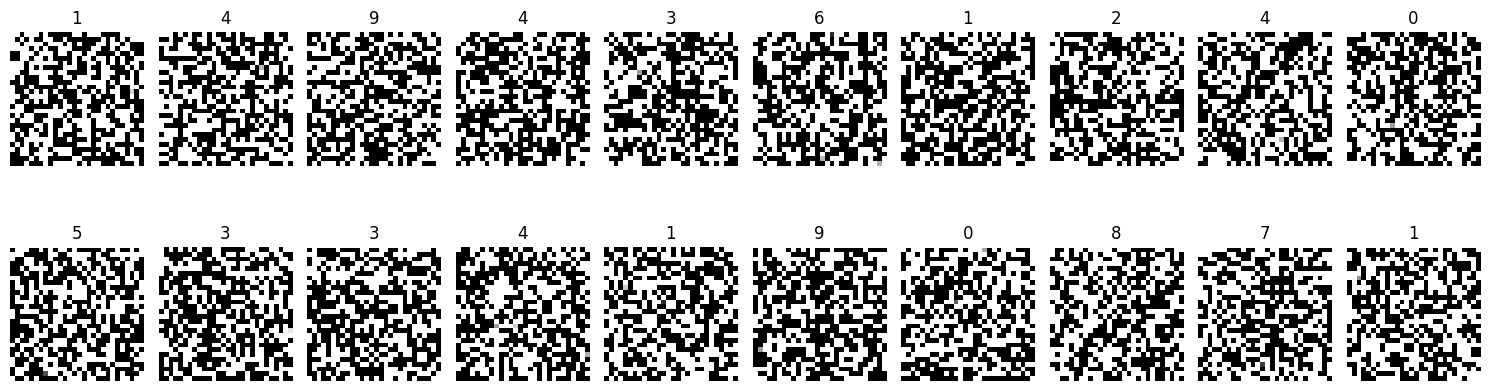

100%|██████████| 469/469 [01:59<00:00,  3.94it/s]


Epoch 1/10, Loss: 0.0481


100%|██████████| 1000/1000 [00:23<00:00, 42.23it/s]


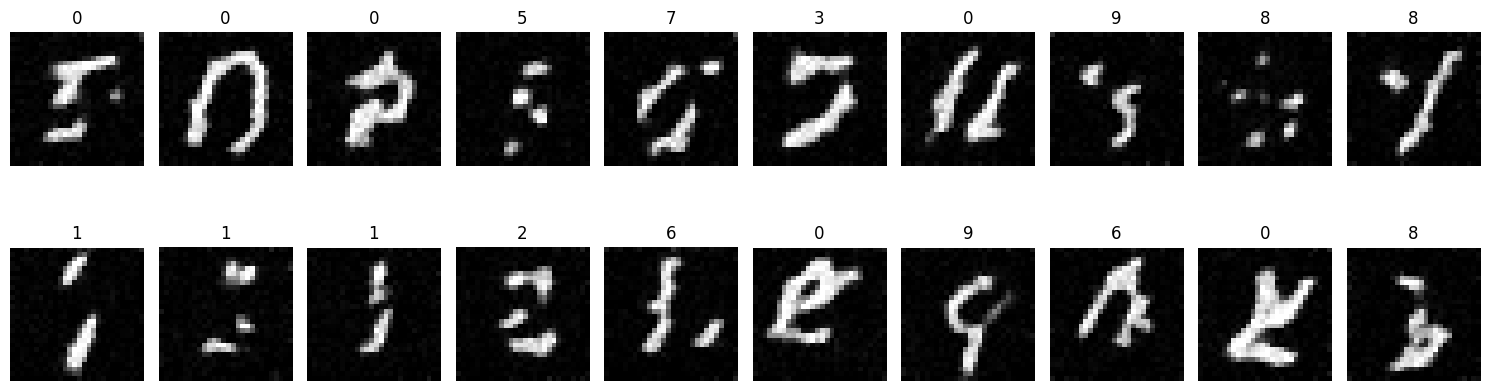

100%|██████████| 469/469 [02:14<00:00,  3.48it/s]


Epoch 2/10, Loss: 0.0264


100%|██████████| 1000/1000 [00:28<00:00, 34.54it/s]


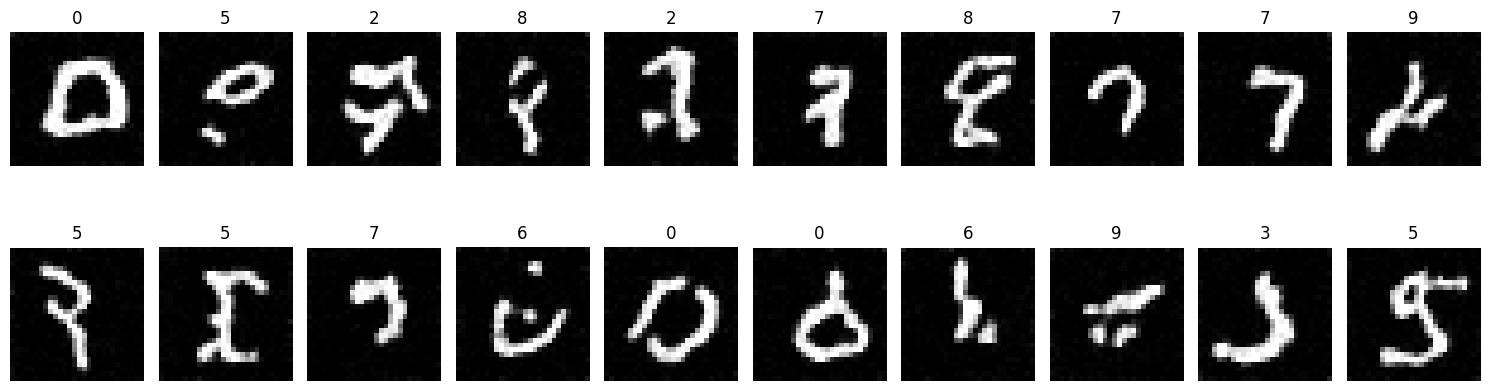

100%|██████████| 469/469 [02:08<00:00,  3.65it/s]


Epoch 3/10, Loss: 0.0231


100%|██████████| 1000/1000 [00:25<00:00, 39.81it/s]


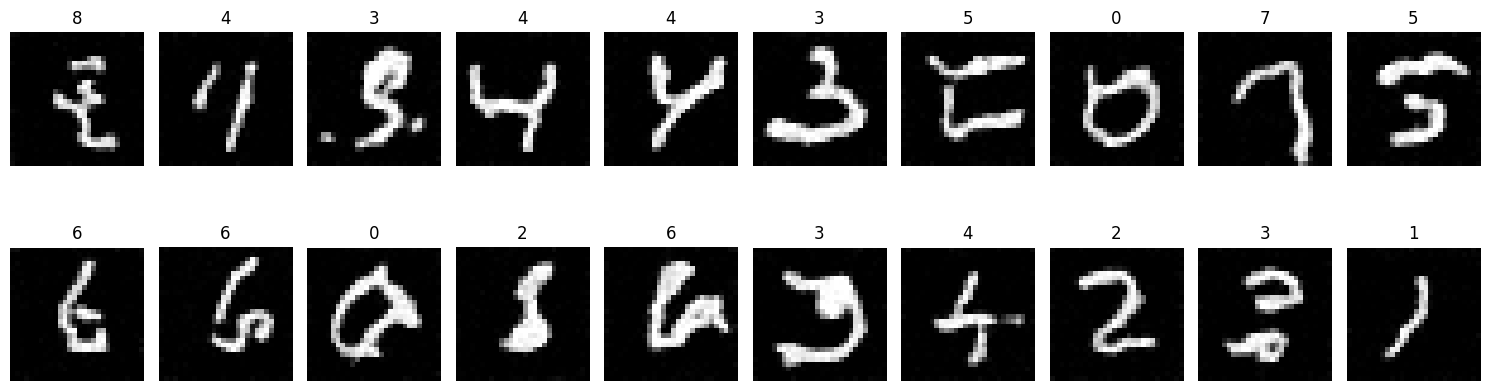

100%|██████████| 469/469 [02:11<00:00,  3.58it/s]


Epoch 4/10, Loss: 0.0212


100%|██████████| 1000/1000 [00:28<00:00, 35.24it/s]


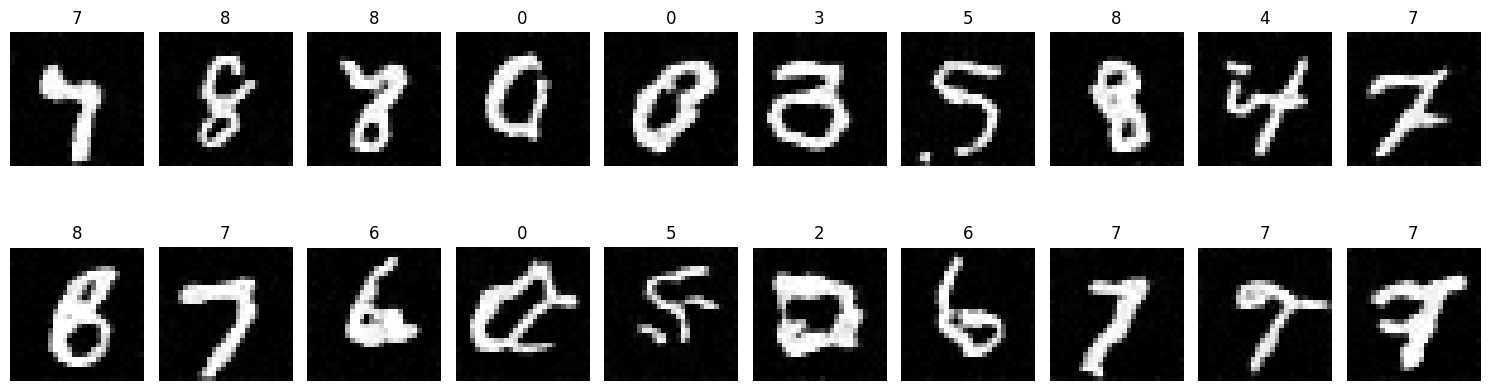

100%|██████████| 469/469 [02:28<00:00,  3.15it/s]


Epoch 5/10, Loss: 0.0198


100%|██████████| 1000/1000 [00:28<00:00, 34.67it/s]


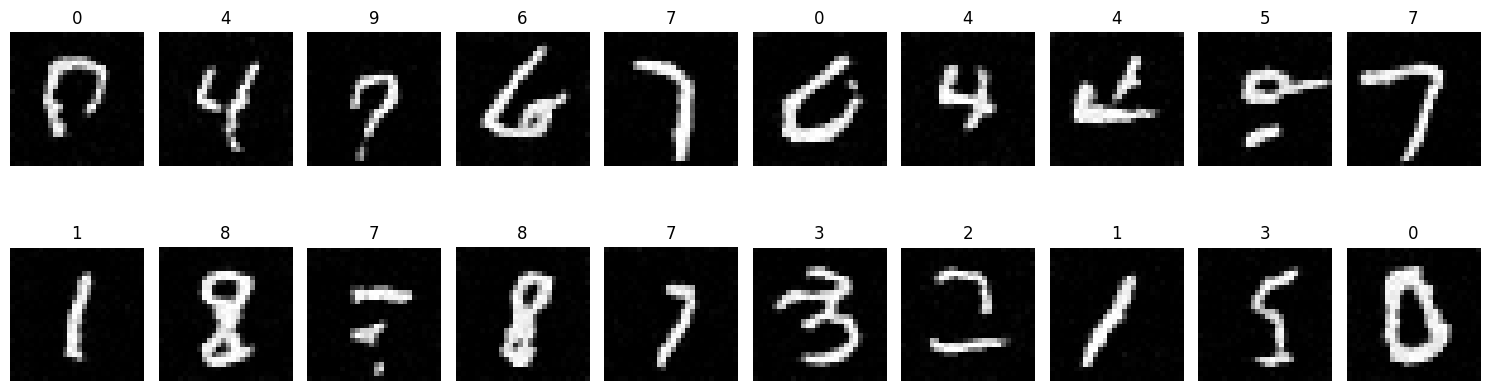

100%|██████████| 469/469 [02:12<00:00,  3.54it/s]


Epoch 6/10, Loss: 0.0195


100%|██████████| 1000/1000 [00:24<00:00, 40.41it/s]


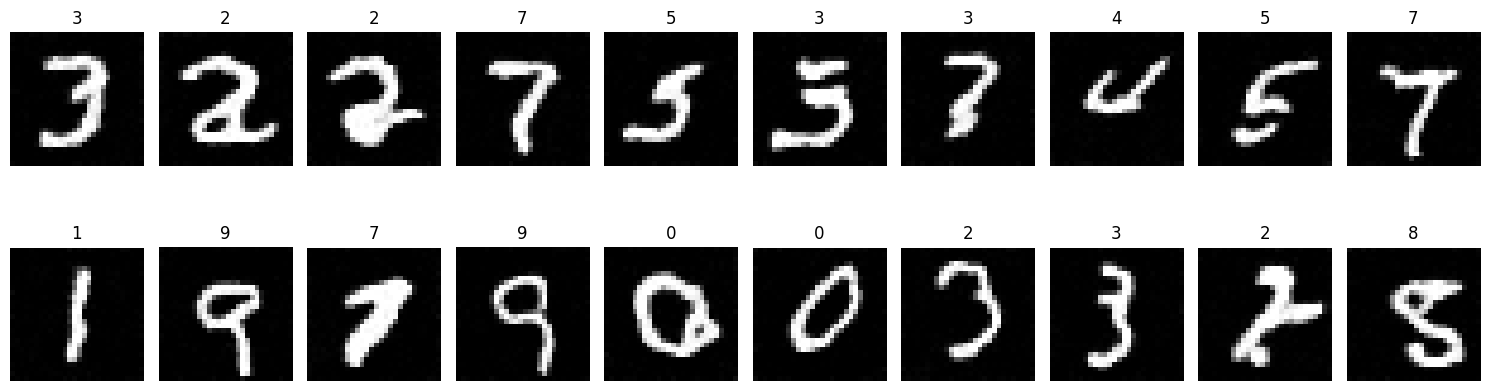

100%|██████████| 469/469 [02:10<00:00,  3.58it/s]


Epoch 7/10, Loss: 0.0187


100%|██████████| 1000/1000 [00:35<00:00, 28.42it/s]


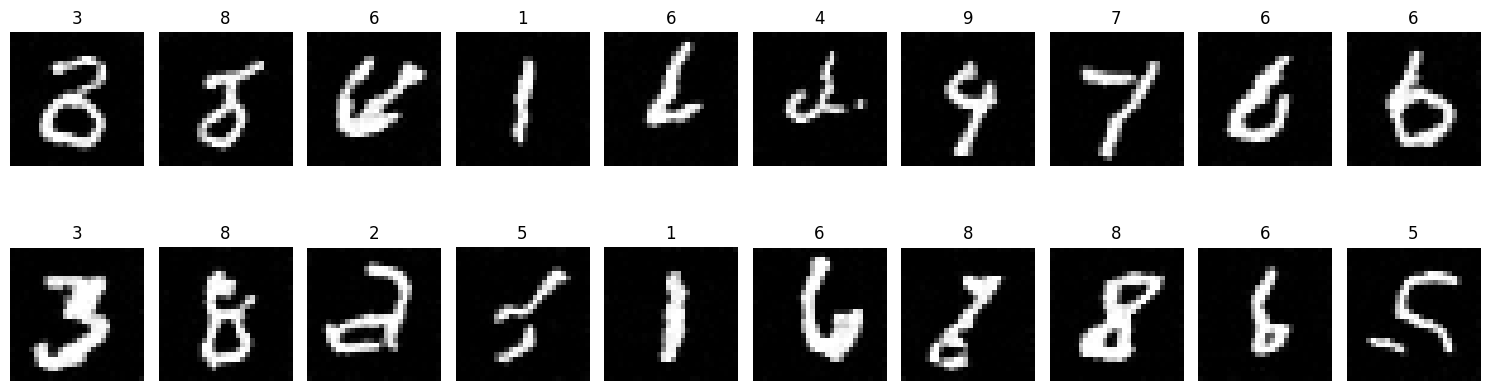

100%|██████████| 469/469 [02:25<00:00,  3.23it/s]


Epoch 8/10, Loss: 0.0178


100%|██████████| 1000/1000 [00:36<00:00, 27.37it/s]


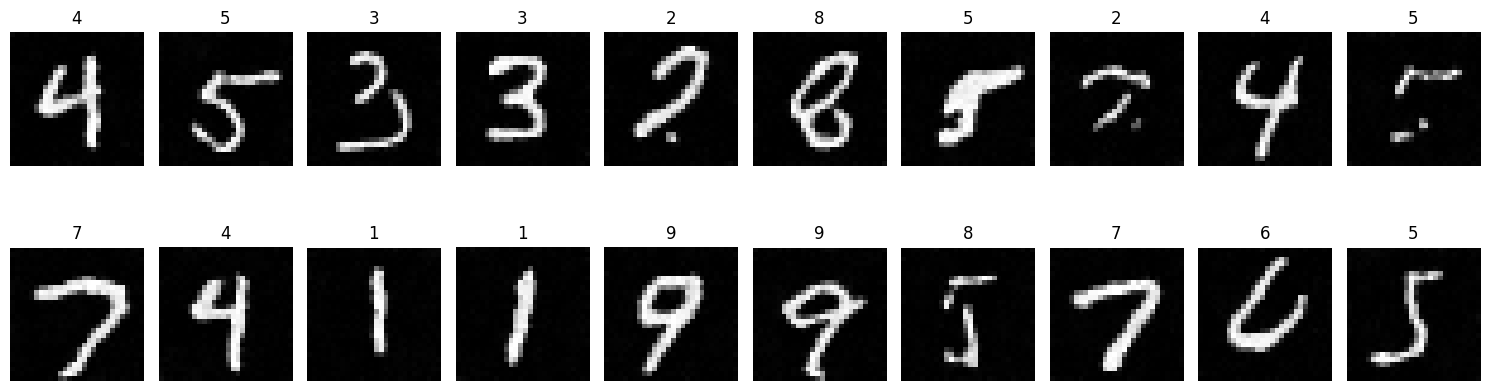

100%|██████████| 469/469 [02:27<00:00,  3.18it/s]


Epoch 9/10, Loss: 0.0173


100%|██████████| 1000/1000 [00:37<00:00, 26.43it/s]


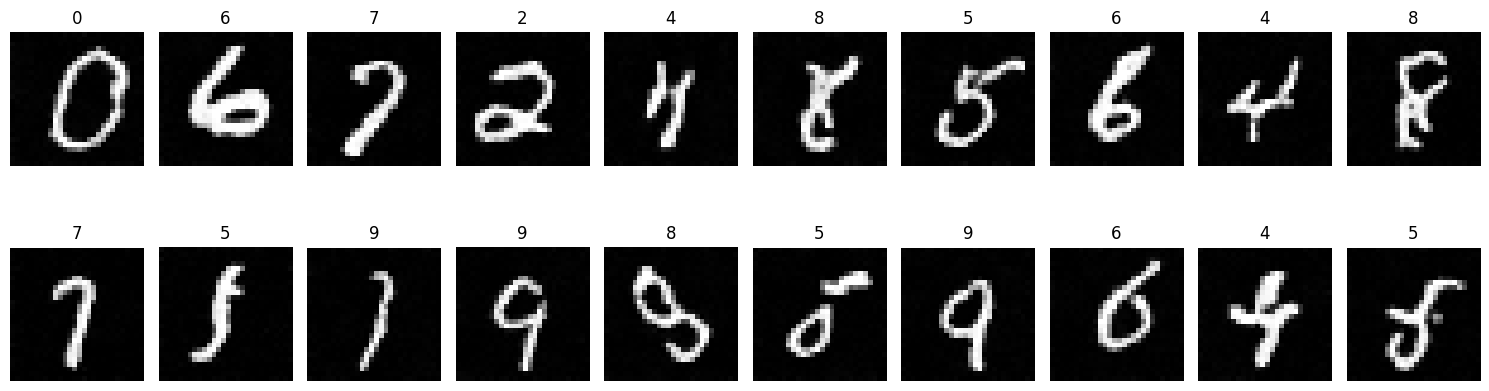

100%|██████████| 469/469 [02:25<00:00,  3.23it/s]

Epoch 10/10, Loss: 0.0173


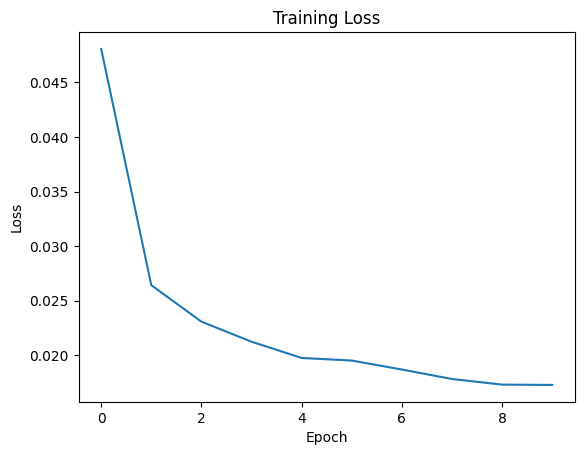

100%|██████████| 1000/1000 [00:34<00:00, 28.91it/s]


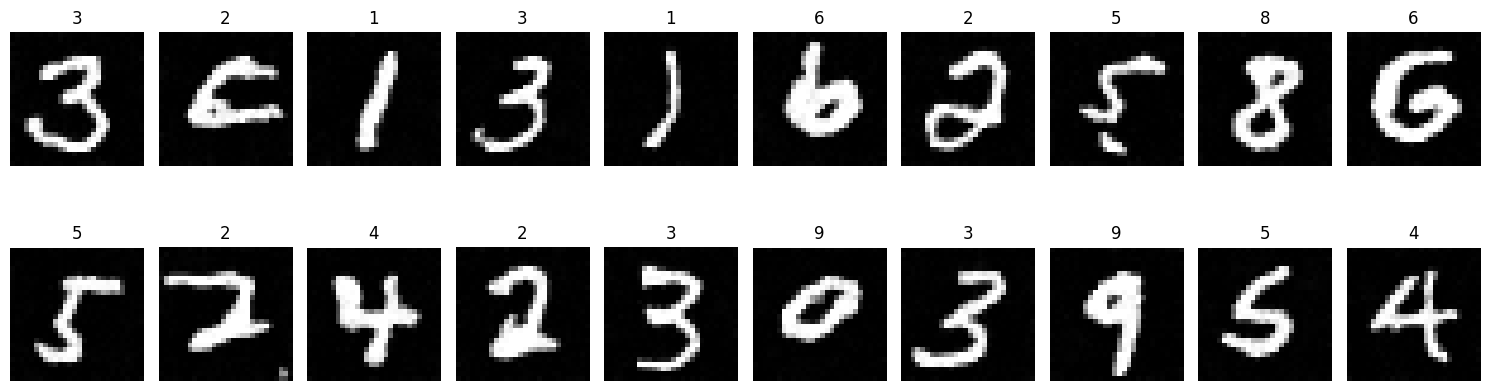

In [6]:
img_size = 28
batch_size = 128
num_timesteps = 1000
epochs = 10
lr = 1e-3
num_labels = 10


def show_images(images, labels, rows=2, cols=10):
    fig = plt.figure(figsize=(15, 5))
    for row in range(rows):
        for col in range(cols):
            idx = row * cols + col
            if idx < len(images):
                ax = fig.add_subplot(rows, cols, idx + 1)
                ax.imshow(images[idx], cmap="gray")
                ax.axis("off")
                ax.set_title(f"{labels[idx].item()}")
    plt.tight_layout()
    plt.show()


transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST("./data", download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size, True)

diffuser = Diffuser(
    num_timesteps=num_timesteps,
    beta_start=0.0001,
    beta_end=0.02,
    device=device,
)
model = UNet(num_labels=num_labels)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr)

losses = []

for epoch in range(epochs):
    loss_sum = 0.0
    count = 0

    images, labels = diffuser.sample(model, labels=num_labels)
    show_images(images, labels)

    for images, labels in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        labels = labels.to(device)
        t = torch.randint(
            1, num_timesteps + 1, (len(x),), device=device, dtype=torch.int64
        )

        x_noisy, noise = diffuser.add_noise(x, t)
        noise_pred = model(x_noisy, t, labels)
        loss = F.mse_loss(noise, noise_pred)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        count += 1

    loss_avg = loss_sum / count
    losses.append(loss_avg)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss_avg:.4f}")

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

images, labels = diffuser.sample(model, labels=num_labels)
show_images(images, labels)

In [7]:
from safetensors.torch import save_file

save_file(
    model.state_dict(),
    "models/cond_diffuser_unet.safetensors",
    metadata={"format": "torch"},
)
print("Model weights saved to models/cond_diffuser_unet.safetensors")

Model weights saved to models/cond_diffuser_unet.safetensors
